In [ ]:
!pip install librosa

#Intro to audio data

In [2]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

In [3]:
print(f"Type array: {type(array)}, type sampling rate: {sampling_rate}\n\nArray size: {array.shape}, Sampling rate = {sampling_rate}")

Type array: <class 'numpy.ndarray'>, type sampling rate: 22050

Array size: (117601,), Sampling rate = 22050


In [4]:
# We can see above that array is 1D denoting samples of audio signal. The example is loaded as a tuple of audio time series.

print(f"Lenght of audio: {array.size/sampling_rate}")

Lenght of audio: 5.333378684807256


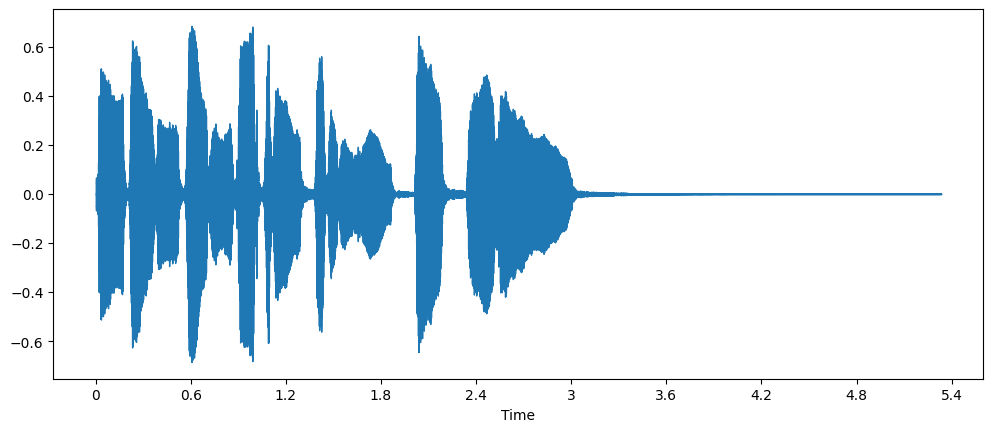

In [5]:
import matplotlib.pyplot as plt
import librosa.display


plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)  #amplitude of the signal on the y-axis

In [6]:
max(array)

np.float32(0.63159853)

##The frequency spectrum

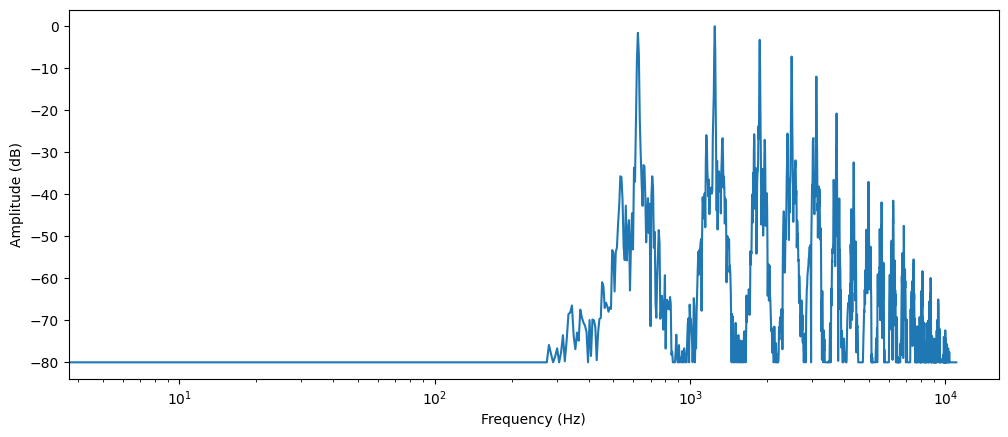

In [7]:
import numpy as np

dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

#This plots the strength of the various frequency components that are present in this audio segment

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

The output of the DFT is an array of complex numbers, made up of real and imaginary components. Taking the magnitude with np.abs(dft) extracts the amplitude information from the spectrogram. The angle between the real and imaginary components provides the so-called phase spectrum, but this is often discarded in machine learning applications.

##Spectrogram

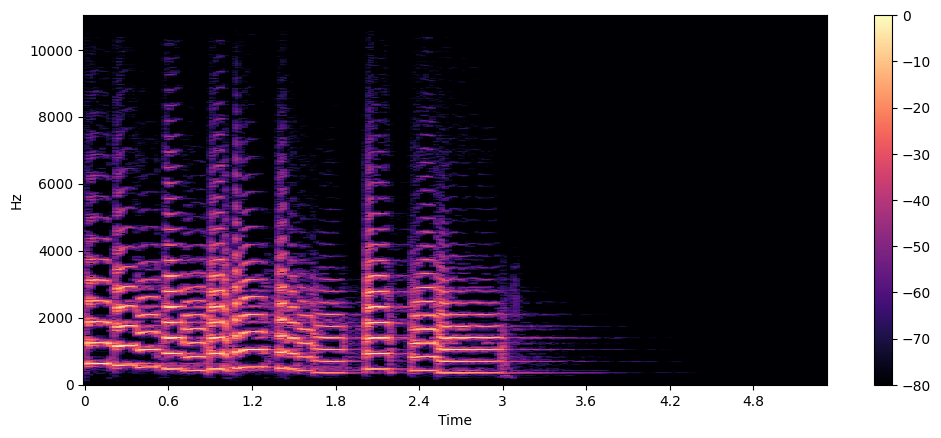

In [8]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

##Mel spectrogram

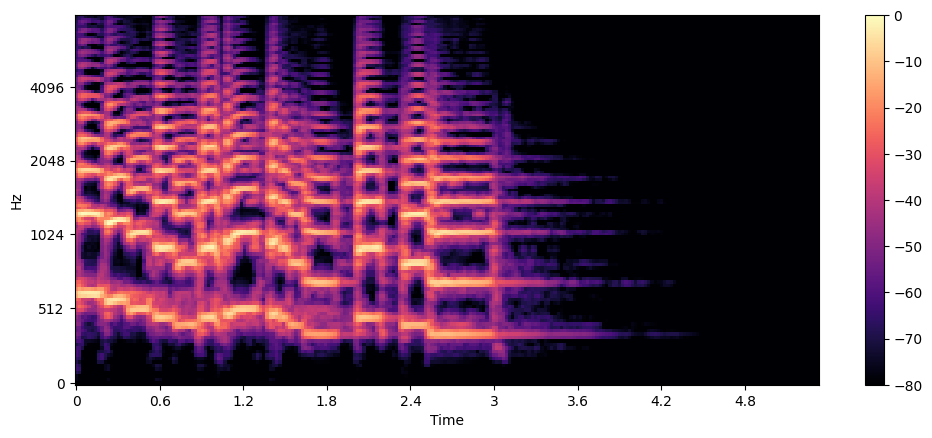

In [9]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In the example above, n_mels stands for the number of mel bands to generate. The mel bands define a set of frequency ranges that divide the spectrum into perceptually meaningful components, using a set of filters whose shape and spacing are chosen to mimic the way the human ear responds to different frequencies. Common values for n_mels are 40 or 80. fmax indicates the highest frequency (in Hz) we care about.

Creating a mel spectrogram is a lossy operation as it involves filtering the signal. Converting a mel spectrogram back into a waveform is more difficult than doing this for a regular spectrogram, as it requires estimating the frequencies that were thrown away. This is why machine learning models such as HiFiGAN vocoder are needed to produce a waveform from a mel spectrogram.

#Load and explore an audio dataset

In [ ]:
!pip install datasets[audio]

In [11]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train") #To load MINDS-14 dataset, use dataset’s identifier on the Hub (PolyAI/minds14). We are choosing Australian subset (en-AU) of the data, and limit it to the training split


README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

minds14.py:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


MInDS-14.zip:   0%|          | 0.00/471M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
print(f"Dataset contains: {minds}\n\nType: {type(minds)}")

Dataset contains: Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

Type: <class 'datasets.arrow_dataset.Dataset'>


In [21]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [29]:
print(f"The shape of array: {(minds[0]['audio']['array']).shape}, sampling rate: {minds[0]['audio']['sampling_rate']}")

The shape of array: (62415,), smapling rate: 8000


In [33]:
print(f"output class in classification task: {minds.unique('intent_class')}")

output class in classification task: [13, 9, 2, 3, 1, 0, 11, 4, 6, 5, 12, 8, 10, 7]


In [34]:
#convert these number into a meaningful string, we can use the int2str() method

id2label = minds.features["intent_class"].int2str

{class_int: id2label(class_int) for class_int in sorted(minds.unique('intent_class'))}

{0: 'abroad',
 1: 'address',
 2: 'app_error',
 3: 'atm_limit',
 4: 'balance',
 5: 'business_loan',
 6: 'card_issues',
 7: 'cash_deposit',
 8: 'direct_debit',
 9: 'freeze',
 10: 'high_value_payment',
 11: 'joint_account',
 12: 'latest_transactions',
 13: 'pay_bill'}

In [35]:
#remove irrelevant features using Datasets remove_columns method

columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [ ]:
!pip install gradio

In [ ]:
#Listen to audio example

import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

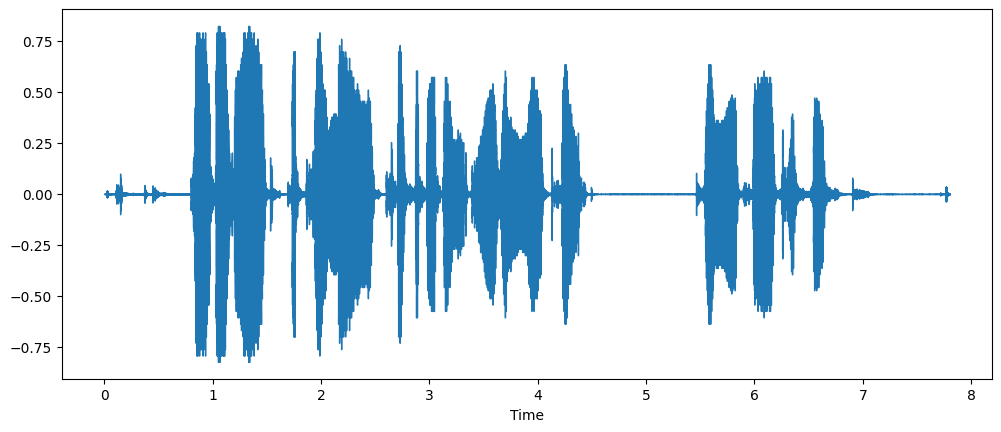

In [40]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

example = minds[0]
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

#Preprocessing an audio dataset

It involves the following steps:

1.   Resampling the audio data
2.   Filtering the dataset
3.   Converting audio data to model’s expected input



In [41]:
#Resampling

from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [42]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [43]:
print(f"The shape of array: {(minds[0]['audio']['array']).shape}, sampling rate: {minds[0]['audio']['sampling_rate']}")

The shape of array: (124830,), sampling rate: 16000


**Filtering the dataset**

We may need to filter the data based on some criteria. One of the common cases involves limiting the audio examples to a certain duration. For instance, we might want to filter out any examples longer than 20s to prevent **out-of-memory errors** when training a model.

In [44]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [45]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

###Pre-processing audio data

Convert raw data into input features.

The requirements for the input features may vary from one model to another — they depend on the model’s architecture, and the data it was pre-trained with. The good news is, for every supported audio model, Transformers (library) offer a feature extractor class that can convert raw audio data into the input features the model expects.

In [46]:
#load the feature extractor from the pre-trained Whisper checkpoint to have ready for our audio data:

from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [48]:
# Preprocess single audio example

def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [49]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

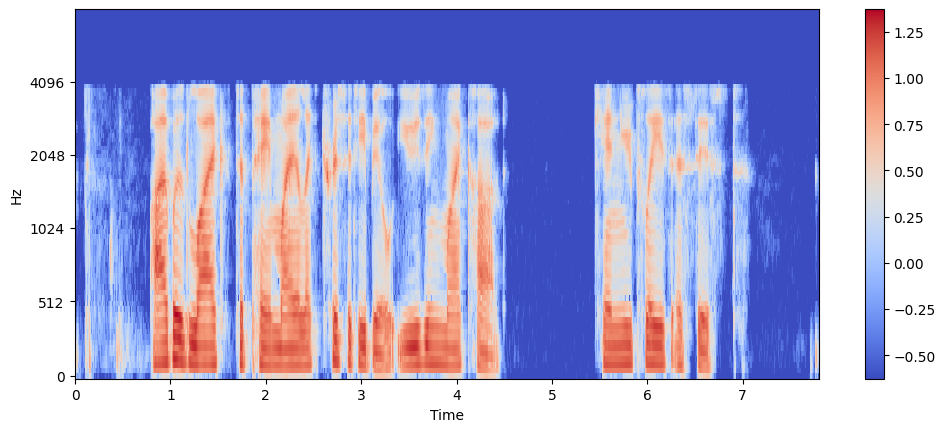

In [50]:
#Visualize

import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

The model’s feature extractor class takes care of transforming raw audio data to the format that the model expects. However, many tasks involving audio are multimodal, e.g. speech recognition. In such cases Transformers (library) also offer model-specific tokenizers to process the text inputs

We can load the feature extractor and tokenizer for Whisper and other multimodal models separately, or you can load both via a so-called processor.

In [51]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

##Stream audio data

🔊 Audio datasets can be huge (GBs to TBs), making full downloads impractical.

✅ HuggingFace Datasets offers `streaming=True` to load data sample-by-sample without downloading the full dataset.

🚀 Benefits: no disk space required, faster experimentation, and immediate data access.

⚠️ Caveat: streamed data isn't cached, so repeated access requires re-streaming.

👉 Use: The only difference is that you can no longer access individual samples using Python indexing (i.e. `gigaspeech["train"][sample_idx]`). Instead, you have to iterate over the dataset. Here’s how you can access an example when streaming a dataset: `next(iter(gigaspeech["train"]))`


In [ ]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)